<a href="https://www.kaggle.com/code/huudatlego/train-model-cicids2017-cleaned?scriptVersionId=284828597" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cicids2017-cleaned-data/cicids2017_cleaned.csv


**Cell 1: Import Thư viện và Load Dữ liệu**

In [2]:
# --- 1. IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
import pandas as pd
import numpy as np
import joblib # Dùng để lưu mô hình

# Thư viện của Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Các thư viện đã được import thành công!")

# --- 2. LOAD DỮ LIỆU SẠCH ---
# Thay thế '/kaggle/input/cicids2017-cleaned-data/cicids2017_cleaned.csv' 
# bằng đường dẫn chính xác đến file của bạn sau khi add data.
try:
    file_path = '/kaggle/input/cicids2017-cleaned-data/cicids2017_cleaned.csv'
    df = pd.read_csv(file_path)
    print("Đã tải thành công file dữ liệu sạch!")
    print(f"Bộ dữ liệu có {df.shape[0]} dòng và {df.shape[1]} cột.")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file dữ liệu. Vui lòng kiểm tra lại đường dẫn file trong phần 'Add Input'.")

# Hiển thị 5 dòng đầu tiên để kiểm tra
df.head()

Các thư viện đã được import thành công!
Đã tải thành công file dữ liệu sạch!
Bộ dữ liệu có 2520751 dòng và 53 cột.


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


**Cell 2: Chuẩn bị Dữ liệu cho Huấn luyện**

In [3]:
# --- 3. TÁCH BIẾN ĐỘC LẬP (X) VÀ BIẾN PHỤ THUỘC (y) ---
# X là tất cả các cột trừ cột 'Attack Type'
X = df.drop('Attack Type', axis=1)

# y là cột 'Attack Type'
y = df['Attack Type']

print("Đã tách X và y.")
print("Số lượng đặc trưng (features) trong X:", X.shape[1])

# --- 4. MÃ HÓA NHÃN (LABEL ENCODING) ---
# Chuyển các nhãn dạng chữ (ví dụ: 'Normal Traffic') thành số (ví dụ: 0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# In ra để xem các lớp và mã số tương ứng
print("\nCác lớp và mã số tương ứng:")
for index, label in enumerate(le.classes_):
    print(f"{label}: {index}")
    
# --- 5. CHIA DỮ LIỆU TRAIN/TEST (Tỷ lệ 70/30) ---
# Chia dữ liệu để có tập huấn luyện và tập kiểm thử riêng biệt
# stratify=y_encoded đảm bảo tỷ lệ các loại tấn công trong tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nKích thước tập huấn luyện (train): {X_train.shape[0]} dòng")
print(f"Kích thước tập kiểm thử (test): {X_test.shape[0]} dòng")

# --- 6. SCALING DỮ LIỆU BẰNG STANDARDSCALER ---
# Chuẩn hóa dữ liệu để các đặc trưng có cùng thang đo, giúp mô hình học tốt hơn
scaler = StandardScaler()

# Dùng fit_transform trên tập train để học các tham số scaling
X_train_scaled = scaler.fit_transform(X_train)

# Chỉ dùng transform trên tập test để áp dụng các tham số đã học từ tập train
X_test_scaled = scaler.transform(X_test)

print("\nĐã thực hiện scaling dữ liệu thành công!")

Đã tách X và y.
Số lượng đặc trưng (features) trong X: 52

Các lớp và mã số tương ứng:
Bots: 0
Brute Force: 1
DDoS: 2
DoS: 3
Normal Traffic: 4
Port Scanning: 5
Web Attacks: 6

Kích thước tập huấn luyện (train): 1764525 dòng
Kích thước tập kiểm thử (test): 756226 dòng

Đã thực hiện scaling dữ liệu thành công!


**THÊM MỚI: THỰC HIỆN TINH CHỈNH SIÊU THAM SỐ (HYPERPARAMETER TUNING)**

In [4]:
### THÊM MỚI: THỰC HIỆN TINH CHỈNH SIÊU THAM SỐ (HYPERPARAMETER TUNING) ###
from sklearn.model_selection import RandomizedSearchCV

print("Bắt đầu quá trình tìm kiếm siêu tham số tối ưu...")

# 1. Định nghĩa không gian tìm kiếm cho các tham số
param_distributions = {
    'n_estimators': [100, 150],             # Thử số lượng cây
    'max_depth': [None, 30, 50],            # Thử độ sâu tối đa
    'min_samples_split': [2, 5],            # Thử số mẫu tối thiểu để chia
    'min_samples_leaf': [1, 2]              # Thử số mẫu tối thiểu ở lá
}

# 2. Khởi tạo mô hình Random Forest cơ bản
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 3. Thiết lập RandomizedSearchCV
# n_iter=4: Sẽ thử 4 kết hợp ngẫu nhiên. Con số này nhỏ để chạy nhanh, bạn có thể tăng lên nếu có thời gian.
# cv=3: Sử dụng 3-fold cross-validation để đánh giá mỗi kết hợp.
# verbose=2: Hiển thị log chi tiết.
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=4,  # <-- Tăng/giảm số lần thử tùy vào thời gian bạn có
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. Chạy quá trình tìm kiếm trên một MẪU NHỎ của tập train để tiết kiệm thời gian
# Lấy 5% dữ liệu train để chạy tuning
X_train_sample = X_train_scaled[:int(len(X_train_scaled)*0.05)]
y_train_sample = y_train[:int(len(y_train)*0.05)]

random_search.fit(X_train_sample, y_train_sample)

# 5. In ra kết quả
print("\n...Tìm kiếm hoàn tất!")
print("Các tham số tốt nhất tìm được là:")
print(random_search.best_params_)

Bắt đầu quá trình tìm kiếm siêu tham số tối ưu...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

...Tìm kiếm hoàn tất!
Các tham số tốt nhất tìm được là:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50}


**Cell 3: Huấn luyện và Đánh giá Mô hình Random Forest**

Sử dụng các tham số sau để huấn luyện mô hình cuối cùng: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50}

Bắt đầu thực hiện Kiểm định chéo 5-fold trên mô hình đã tối ưu...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.3s finished


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.8s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.4s


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.1s finished


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.0s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.8s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.6s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.0s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.2s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.7s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.2s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.3min finished



...Kiểm định chéo hoàn tất!
--> Cross-Validation Scores của mô hình tối ưu: [0.99891189 0.99908191 0.99896006 0.99898273 0.99885522]
--> Cross-Validation Mean Score: 0.9990 ± 0.0001

Bắt đầu quá trình huấn luyện mô hình cuối cùng trên toàn bộ tập train...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


...Huấn luyện hoàn tất!

Đang thực hiện dự đoán trên tập kiểm thử...


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.7s finished


...Dự đoán hoàn tất!

Báo cáo Phân loại (Classification Report) với 4 chữ số thập phân:
                precision    recall  f1-score   support

          Bots     0.8723    0.7021    0.7780       584
   Brute Force     1.0000    0.9989    0.9995      2745
          DDoS     0.9999    0.9996    0.9998     38404
           DoS     0.9986    0.9976    0.9981     58124
Normal Traffic     0.9994    0.9993    0.9994    628518
 Port Scanning     0.9892    0.9991    0.9941     27208
   Web Attacks     0.9921    0.9736    0.9827       643

      accuracy                         0.9989    756226
     macro avg     0.9788    0.9529    0.9645    756226
  weighted avg     0.9989    0.9989    0.9989    756226


Ma trận Nhầm lẫn (Confusion Matrix):


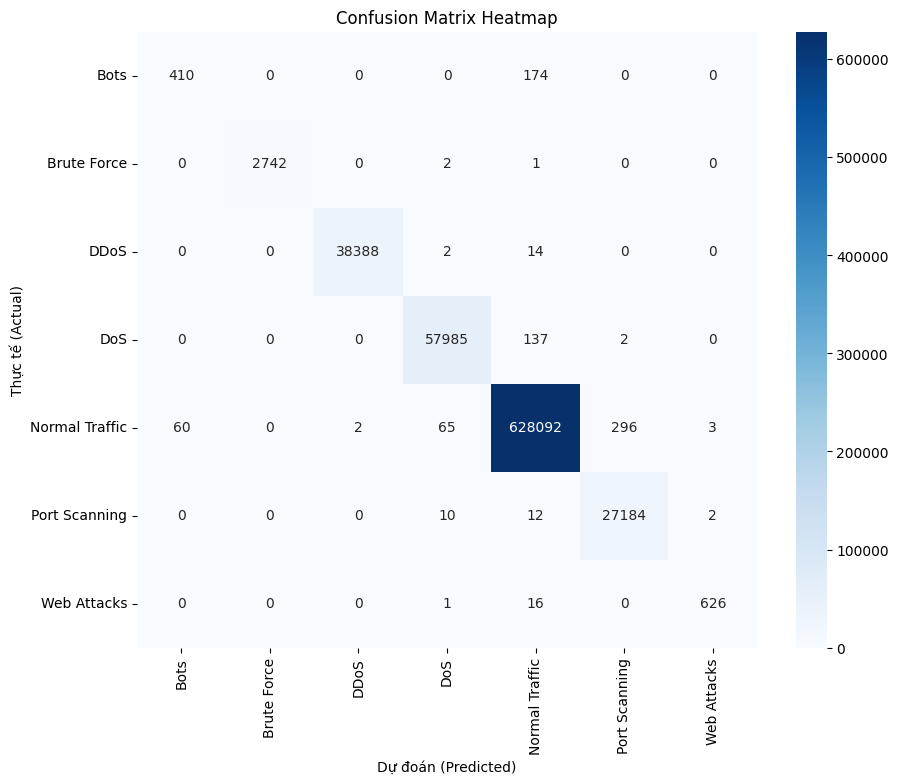


Độ chính xác tổng thể cuối cùng (tính từ Ma trận Nhầm lẫn): 99.8943%


In [5]:
# --- 7. XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH VỚI THAM SỐ TỐT NHẤT ---

# Lấy các tham số tốt nhất đã tìm được từ bước Randomized Search ở cell trước
# Nếu bạn không chạy lại cell tuning, bạn có thể gán thủ công ở đây
# Ví dụ: best_params = {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
try:
    best_params = random_search.best_params_
except NameError:
    print("Biến 'random_search' không tồn tại. Sử dụng bộ tham số mặc định đã chọn.")
    best_params = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1
    }

print(f"Sử dụng các tham số sau để huấn luyện mô hình cuối cùng: {best_params}\n")


# Khởi tạo mô hình Random Forest với các siêu tham số đã được TỐI ƯU HÓA
# Toán tử **best_params sẽ tự động điền các giá trị từ dict vào
rf_model_tuned = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbose=1
)


# --- 7.1. KIỂM ĐỊNH CHÉO LẦN NỮA VỚI MÔ HÌNH TỐI ƯU (Tùy chọn nhưng nên có) ---
# Bước này để xác nhận lại sự ổn định của bộ tham số tốt nhất trên toàn bộ tập train
from sklearn.model_selection import cross_val_score
print("Bắt đầu thực hiện Kiểm định chéo 5-fold trên mô hình đã tối ưu...")
# cv=5 nghĩa là chia tập train ra 5 phần
# n_jobs=-1 để chạy song song, tăng tốc
cv_scores = cross_val_score(rf_model_tuned, X_train_scaled, y_train, cv=5, n_jobs=-1, verbose=1)
print("\n...Kiểm định chéo hoàn tất!")
print(f"--> Cross-Validation Scores của mô hình tối ưu: {cv_scores}")
print(f"--> Cross-Validation Mean Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}\n")


# --- 7.2. HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG ---
print("Bắt đầu quá trình huấn luyện mô hình cuối cùng trên toàn bộ tập train...")
# Huấn luyện mô hình trên toàn bộ dữ liệu train đã được scaling
rf_model_tuned.fit(X_train_scaled, y_train)
print("...Huấn luyện hoàn tất!")


# --- 8. ĐÁNH GIÁ HIỆU NĂNG MÔ HÌNH TRÊN TẬP TEST ---
print("\nĐang thực hiện dự đoán trên tập kiểm thử...")
# Dùng mô hình đã huấn luyện để dự đoán trên tập test
y_pred = rf_model_tuned.predict(X_test_scaled)
print("...Dự đoán hoàn tất!")


# --- 8.1. IN BÁO CÁO PHÂN LOẠI ---
print("\nBáo cáo Phân loại (Classification Report) với 4 chữ số thập phân:")
# Thêm tham số digits=4 để có kết quả chi tiết
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))


# --- 8.2. VẼ MA TRẬN NHẦM LẪN ---
print("\nMa trận Nhầm lẫn (Confusion Matrix):")
cm = confusion_matrix(y_test, y_pred)
# Vẽ heatmap cho ma trận nhầm lẫn để dễ nhìn hơn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix Heatmap')
plt.show()


# --- 8.3. IN ĐỘ CHÍNH XÁC TỔNG THỂ ---
# Tính lại từ Ma trận Nhầm lẫn để có con số chính xác nhất
accuracy_from_cm = np.trace(cm) / np.sum(cm)
print(f"\nĐộ chính xác tổng thể cuối cùng (tính từ Ma trận Nhầm lẫn): {accuracy_from_cm * 100:.4f}%")

**Cell 4: Lưu lại Mô hình và các Công cụ**

In [6]:
# --- 9. LƯU LẠI CÁC "SẢN PHẨM" ĐỂ TRIỂN KHAI ---
# Tạo tên file
model_filename = 'botnet_model.pkl'
scaler_filename = 'scaler.pkl'
encoder_filename = 'label_encoder.pkl'

# Dùng joblib để lưu các đối tượng Python
# SỬA LỖI: Thay 'rf_model' bằng 'rf_model_tuned'
joblib.dump(rf_model_tuned, model_filename)

# Hai dòng này đã đúng vì biến 'scaler' và 'le' được tạo ở Cell 2
joblib.dump(scaler, scaler_filename)
joblib.dump(le, encoder_filename)

print(f"Đã lưu thành công 3 files vào thư mục /kaggle/working/:")
print(f"- Mô hình: {model_filename}")
print(f"- Scaler: {scaler_filename}")
print(f"- Label Encoder: {encoder_filename}")

Đã lưu thành công 3 files vào thư mục /kaggle/working/:
- Mô hình: botnet_model.pkl
- Scaler: scaler.pkl
- Label Encoder: label_encoder.pkl
